# Machine Vision Neural Network tutorial---Part 2
Author: Daniel E. Worrall, 3 Dec 2016

You are going to write a script to run a 7-layer autoencoder. We have
supplied the structure and the pre-trained weights for the autoencoder to
run out-of-the-box. The model is:

input --> encoder --> latent_code --> decoder --> reconstruction

Start by running this script and see what the output gives. You should see that you can generate images that look like numbers by generating random latent codes from a 500D standard Gaussian and passing these vectors through the decoder. Your task will be to find the subspace of the latent code, such that you can smoothly interpolate between numbers in latent space.

## Load data and add files

In [1]:
import matplotlib
matplotlib.use('TkAgg')
%load_ext autoreload
%autoreload 2

import sys
import itertools

import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
np.seterr(all='ignore') # Ignore overflows

from scipy.io import loadmat

from mlp import mlp_forward

In [2]:
# Generate data
mnist_images = loadmat('mnist_test')
mnist_images = mnist_images['X']

# Load params
weights = loadmat('weights')

### Build MLP
Construct the network as an ordered cell array, where each element is alayer

In [3]:
# Import neural network architecture and plotting functions
# No need to read below here (unless you're keen)
from utils import build_encoder, build_decoder, plot_tiled_array

encoder = build_encoder(weights)
decoder = build_decoder(weights)

## Inference
# Forward
n_samples = 225

### Ignore this, which is used for plotting

In [4]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:1000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

## 1) TODO: Plot some input data points

<IPython.core.display.Javascript object>


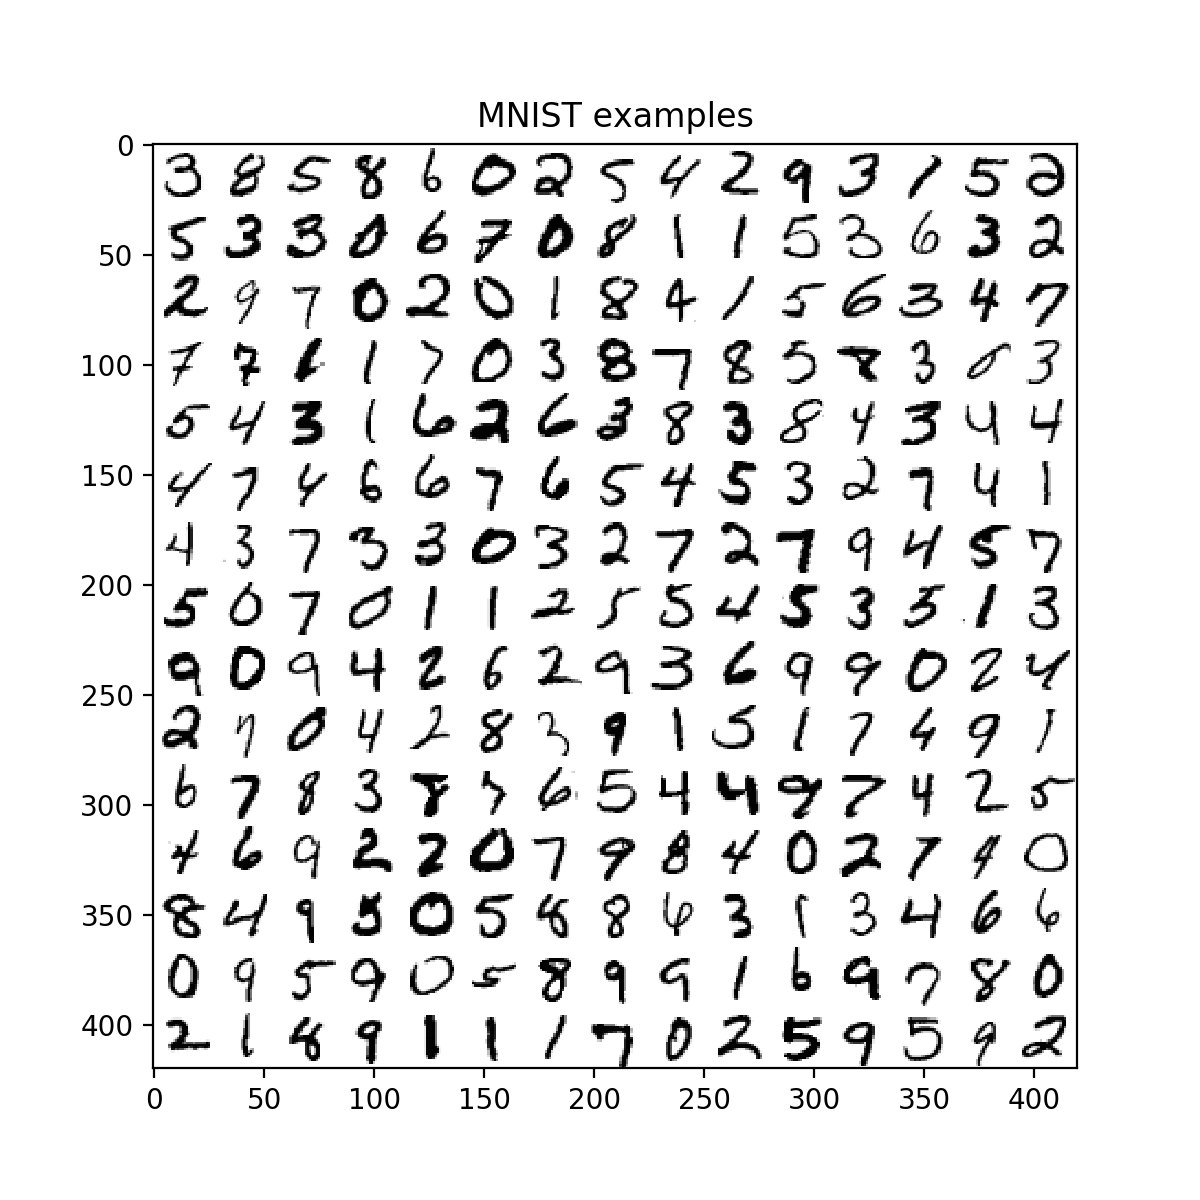

Text(0.5,1,'MNIST examples')

In [5]:
plt.figure(2, figsize=(6,6))
plot_tiled_array(mnist_images[:n_samples,:])
plt.title('MNIST examples')

## 2) TODO: Generate 225 random codes as a draw from a 500D standard Gaussian. 

You should see that the decoder is able to produce convincing images of handwritten digits from random Gaussian draws. What happens if you increase the variance of the draws, by say a factor of 10? Why does this happen?

How are these different from Part 1?

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: covariance is not positive-semidefinite.
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


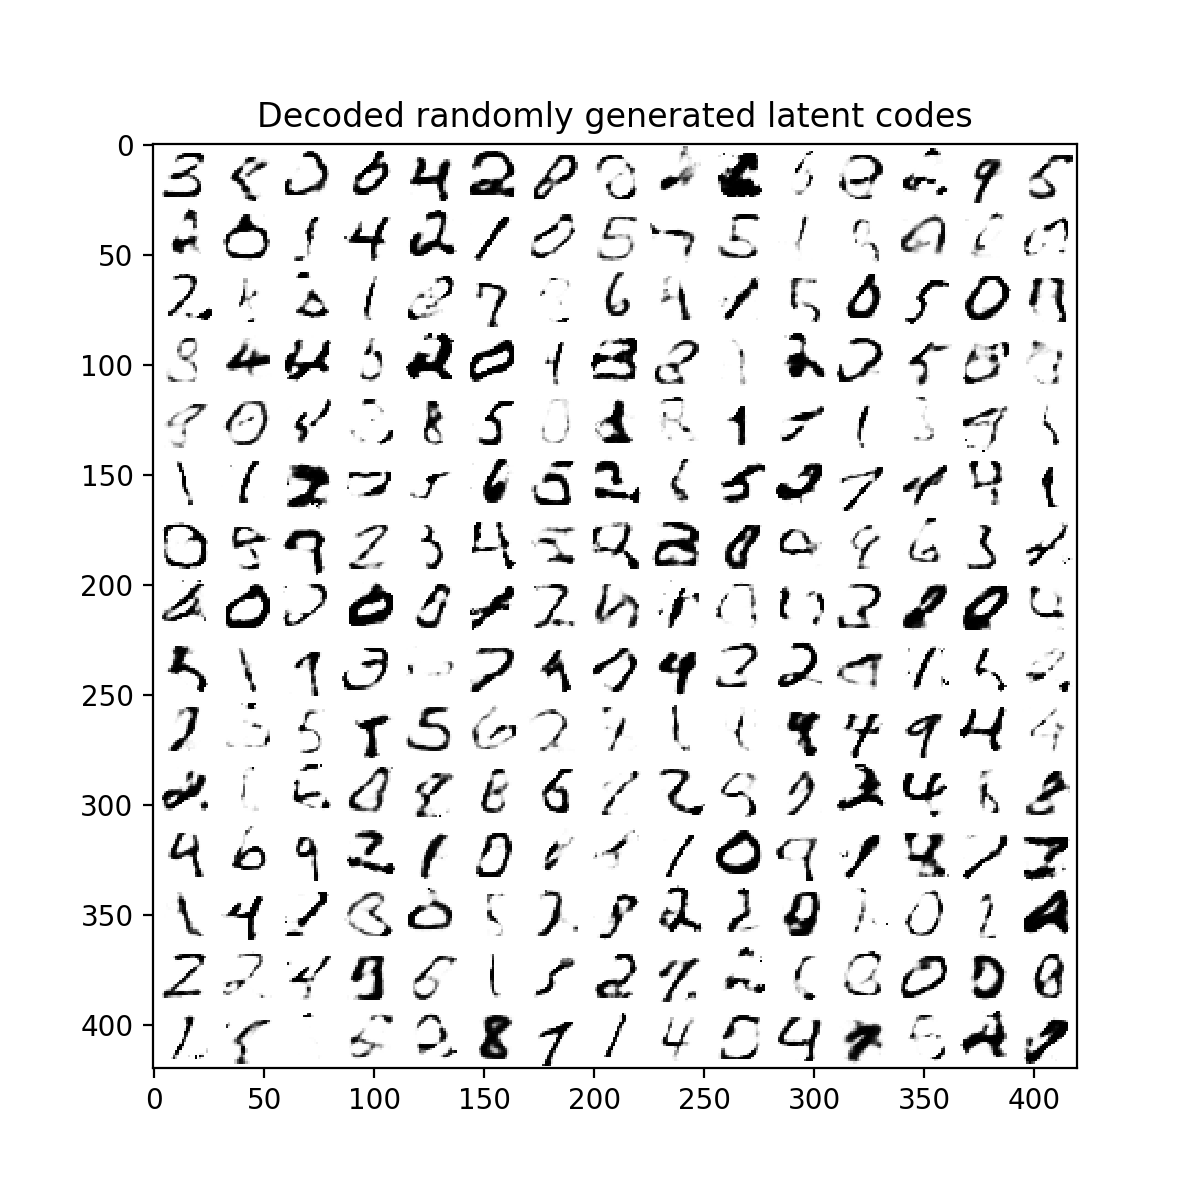

Text(0.5,1,'Decoded randomly generated latent codes')

In [78]:
mean = np.random.randn(500)
cov = np.random.rand(500,500) * 1
latent_code = np.random.multivariate_normal(mean, cov, 225)
reconstruction, __ = mlp_forward(decoder, latent_code)

plt.figure(1, figsize=(6,6))
plot_tiled_array(reconstruction)
plt.title('Decoded randomly generated latent codes')

In the next section, you are going to build a linear approximation to the data-manifold in the latent space of the autoencoder. When you walk along this manifold, you will be able to smoothly interpolate between digits, effectively enforcing a smooth ordering on the data.

In [26]:
# Create sampling grid in a 2D subspace
lim = 3;
image_dims =int(np.ceil(np.sqrt(n_samples)))
lin_range = np.linspace(-lim,lim,image_dims)
X, Y = np.meshgrid(lin_range, lin_range)
sampling_grid = np.concatenate([np.reshape(Y,[n_samples,1]), np.reshape(X,[n_samples,1])], axis=1)

## 3) TODO: Generate a random 500D subspace with 2 degrees of freedom.
You can do this by generating two random vectors. See what happens when you run this several times. Are all the images you generate valid digits?

<IPython.core.display.Javascript object>


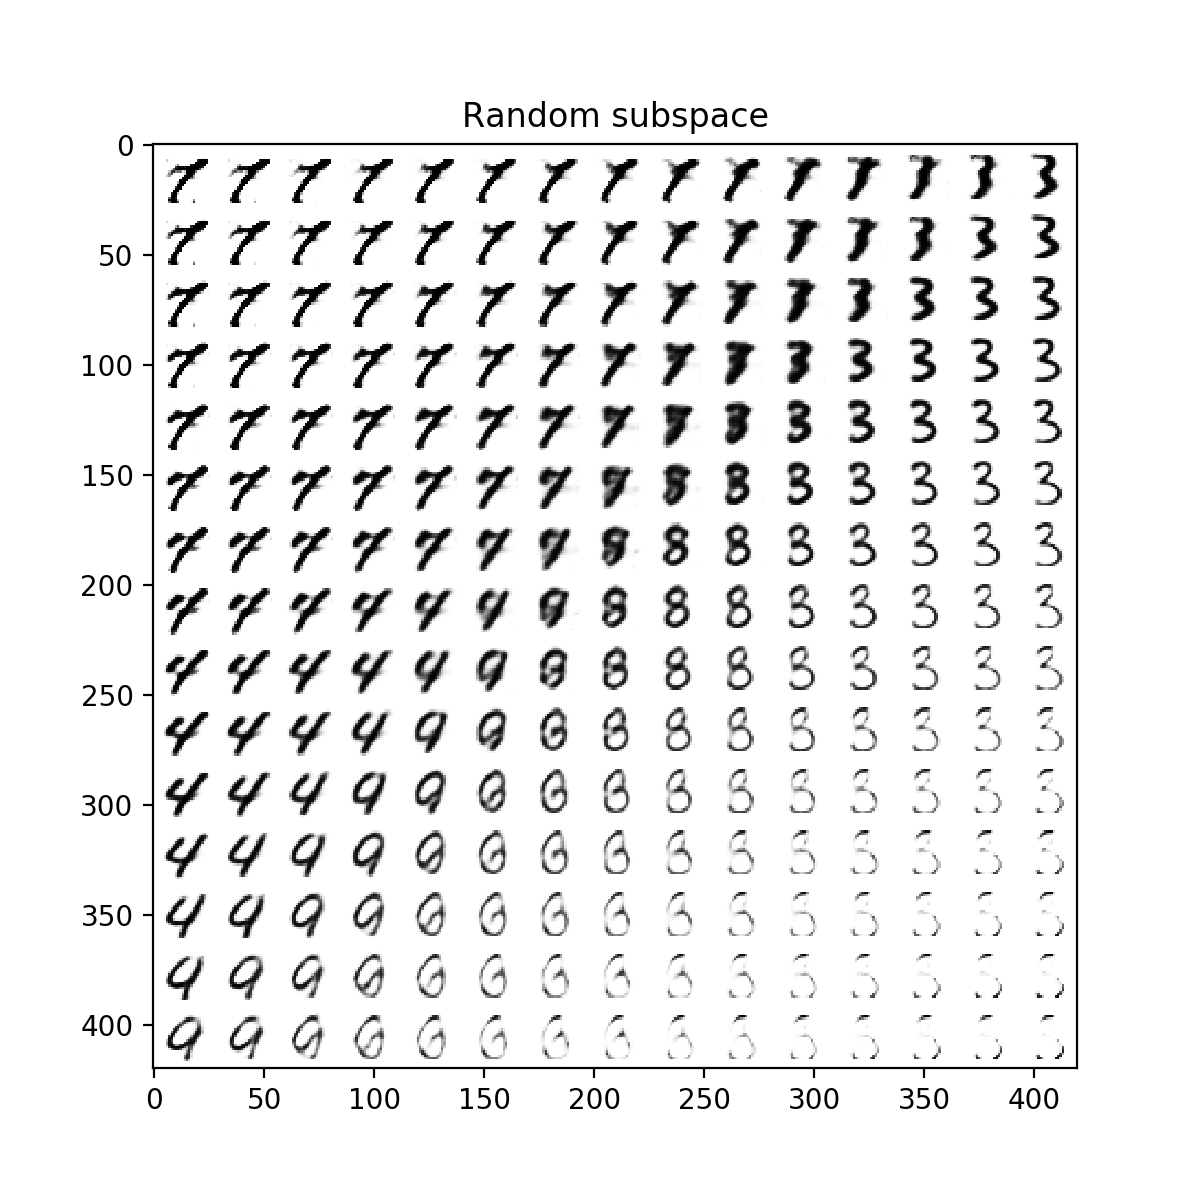

Text(0.5,1,'Random subspace')

In [71]:
subspace = np.random.rand(2,500)
latent_code = sampling_grid@subspace

# Reconstruct images from code
reconstruction, __ = mlp_forward(decoder, latent_code)

plt.figure(3, figsize=(6,6))
plot_tiled_array(reconstruction)
plt.title('Random subspace')

You will now forward pass `mnist_images` through the encoder so that you have a collection of latent data points. Run PCA on the latent codes and keep the first two principal directions. Compare the quality of these digits to those of the random subspaces. What do you notice? Do you think a linear manifold is a good approximation to the true data manifold? 

In [72]:
latent_code, __ = mlp_forward(encoder, mnist_images)

## 4.1) TODO: Compute the covariance matrix of the latent codes

In [73]:
latent_cov = np.cov(latent_code.T)

## 4.2) TODO: Do PCA on the sampled code
Perform the SVD on the covariance matrix and retain the first two rows of V (as a column)

<IPython.core.display.Javascript object>


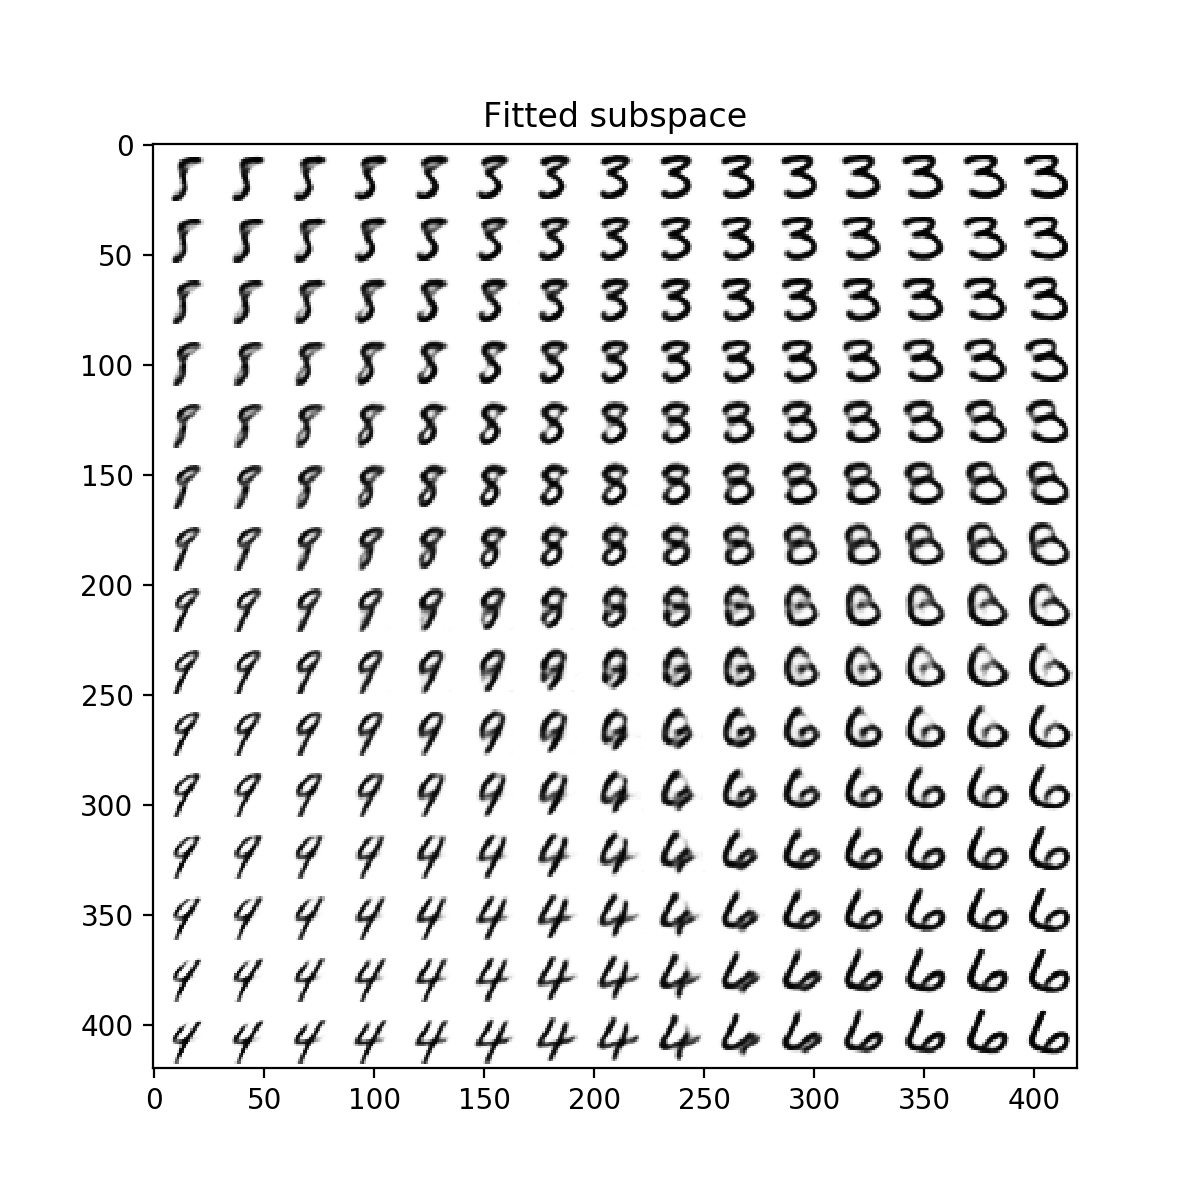

Text(0.5,1,'Fitted subspace')

In [76]:
U, S, Vh = np.linalg.svd(latent_cov)
principal_subspace = Vh[:2,:]

latent_grid = sampling_grid@principal_subspace
# Reconstruct images from the codes
reconstruction, __ = mlp_forward(decoder, latent_grid)

plt.figure(4, figsize=(6,6))
plot_tiled_array(reconstruction)
plt.title('Fitted subspace')

## OPTIONAL EXTENSIONS
In this section you may use whatever Python functionality you see fit to use.

OPTIONAL 10b-i: Easy
What happens if you pass the reconstruction from the decoder back into the encoder? What happens if you do this T times? Try adding a little isotropic Gaussian noise to the latent code every time you do this. What does this do?

OPTIONAL 10b-ii: Moderate
Run a k-means clustering algorithm in the latent space. What do you find?

OPTIONAL 10b-iii: Difficult
Port some new data to the script, say the Frey Faces dataset (easy to find online). Now replace the final sigmoid layer in the decoder and try to train an encoder yourself on this.

OPTIONAL 10b-iv: Difficult
Read Autoencoding Variational Bayes by (Kingma et al., 2014). The pretrained weights for this autoencoder were trained using this setup. If you look carefully at weights.mat, you will see that there is an extra set of weights for the encoder "encoder_W_e_sigma", which we do not use. Can you implement a stochastic encoder layer?